In [1]:
% matplotlib inline

import numpy as np

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
from scipy.special import gammaln
from scipy.stats import chisquare, chi2

from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import h5py
import pywt

import readligo as rl

In [2]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs)/dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [3]:
fs = 4096 # sampling rate

# get segment list. note that for now, I'm only using a small amount of
# data (1 file), but that this should be expandable to many more (currently
# I have about 50GB worth of data cached on my home desktop, which should
# be more than enough for this)
start = 931049472
stop = start+4096
segList = rl.getsegs(start, stop, 'H1', flag='DATA')

Using data directory . ...


/home/jacaseyclyde/.local/lib/python2.7/site-packages/ipykernel/__main__.py:94: RuntimeWarning: divide by zero encountered in log


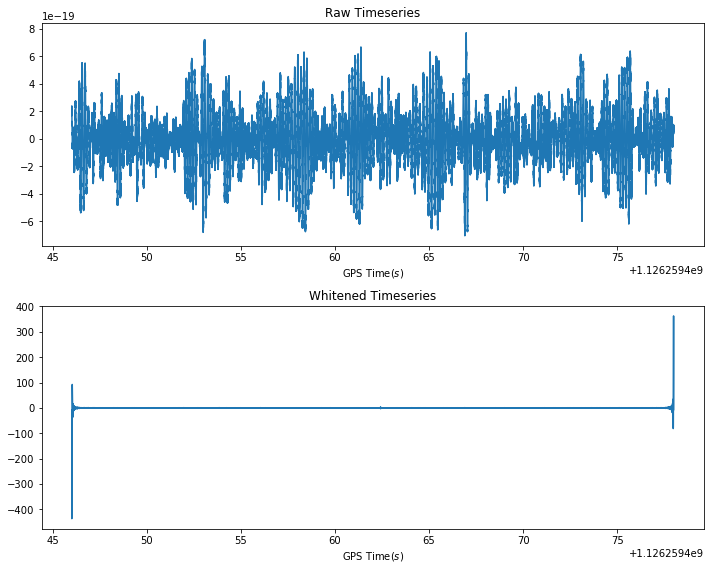

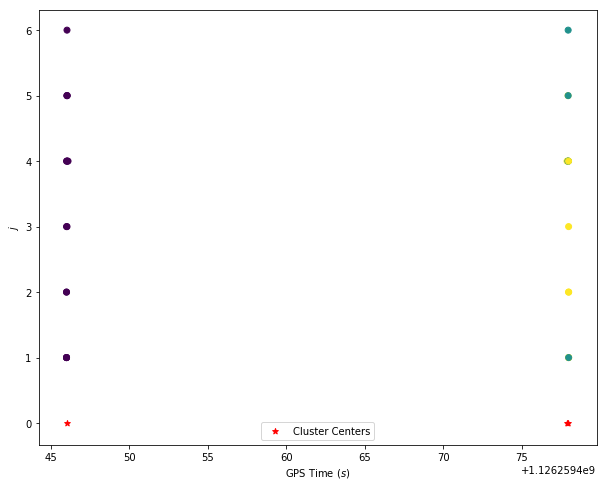

[[  1.12625945e+09   1.12625945e+09]
 [  1.12625948e+09   1.12625948e+09]
 [  1.12625948e+09   1.12625948e+09]]


In [11]:
# loop over good segments
fn_H1 = 'cache/H-H1_LOSC_4_V2-1126259446-32.hdf5'
# 'H-H1_LOSC_4_V2-1126257414-4096.hdf5'
strain, time, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
begin = time[0]
end = time[-1]
ts = time[1]-time[0]

event_times = np.array([])
for q in [0]: #for (begin, end) in segList:
    #strain, meta, dq = rl.getstrain(begin, end, 'H1')
    #ts = meta['dt']
    
    # first whiten strain data
    NFFT = 1*fs    
    Pxx, freqs = mlab.psd(strain, Fs=fs, NFFT=NFFT)
    psd = interp1d(freqs, Pxx)
    
    strain_whiten = whiten(strain,psd,ts)
    
    bb, ab = butter(4, [20.*2./fs, 300.*2./fs],btype='band') #butterworth bandpass
    strain_whitenbp = filtfilt(bb, ab, strain_whiten)
    
    # plot of the whitened data and unwhitened data
    # not really relevant to final goals, but it shows the whitening is working!
    figure1 = plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    rel_time = np.arange(begin, end+ts, ts)
    
    plt.plot(rel_time, strain)
    plt.title('Raw Timeseries')
    plt.xlabel('GPS Time($s$)')
    
    plt.subplot(2,1,2)
    plt.plot(rel_time, strain_whitenbp)
    plt.title('Whitened Timeseries')
    plt.xlabel('GPS Time($s$)')
    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    
    #------------------------------------------------------------
    
    # then wavelet decomposition.
    # returns [cA_n, cD_n, cD_n-1, ..., cD2, cD1]
    # where n is the decomposition level, and cA are the approximation coefficient arry
    # while cD are details coefficient arrays
    coeffs = pywt.wavedec(strain_whitenbp, 'haar') # using haar for now, as thats what LIGO apparently uses for this. will do more research later to verify reasoning
    D_coeffs = np.flipud(coeffs[1:]) # switching the order so that D_coeffs[i] corresponds to j=i+1 decomp level
    
    E_coeffs = []
    seg_times = []
    all_scales = []
    for scale, D_co in enumerate(D_coeffs):
        N = len(D_co)
        sigma = np.std(D_co)
        if (sigma == 0):
            break
        sig_px = np.where((D_co / sigma) > 4.)[0]
        
        scales = np.full(np.shape(sig_px),scale+1,dtype=np.int64)

        times = np.full(np.shape(sig_px),begin,dtype=np.float64)
        for i in range(len(sig_px)):
            times[i] += ((2.**(scale+1.)) / fs) * sig_px[i]
            
        seg_times = np.append(seg_times, times)
        all_scales = np.append(all_scales,scales).astype(np.int64)

        E_coeffs = np.append(E_coeffs,((D_co**2) /  (np.std(D_co)**2))[sig_px])
    
    data = np.vstack((seg_times, all_scales * ts)).T # multiplying by ts to rescale the scale axis
    
    ms = MeanShift()
    ms.fit(data)
    
    labels = ms.labels_
    centers = ms.cluster_centers_
    
    fig2 = plt.figure(figsize=(10,8))
    plt.scatter(seg_times,all_scales,c=labels,cmap=plt.cm.viridis)
    plt.scatter(centers[:,0],centers[:,1],marker='*',c='r',label='Cluster Centers')
    plt.legend()
    plt.title('')
    plt.xlabel('GPS Time ($s$)')
    plt.ylabel('$j$')
    
    #------------------------------------------------------------
    for label in np.unique(labels):
        pts = np.where(labels==label)
        clust = E_coeffs[pts]
        E_c = np.sum(clust)
        x = np.linspace(0,1000,1000)
    
        signif = -np.log(quad(chi2.pdf, E_c, np.inf, args=(len(clust),))[0])
        if (signif > 20.):
            if (len(event_times) == 0):
                event_times = np.array([min(seg_times[pts]),max(seg_times[pts])])
            else:
                time_coords = np.array([min(seg_times[pts]),max(seg_times[pts])])
                event_times = np.vstack((event_times,time_coords))
    
plt.show()
print(event_times)
#event_times.tofile('times', sep=' ')
np.savetxt('times', event_times)